In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.engine import DDIMSampler  # or DDPMSampler if you prefer
from model.UNet    import UNet

# 1) Point this to your trained checkpoint
checkpoint_path = "checkpoint/gedi_treecover_e4.pth"

# 2) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3) Load checkpoint
cp = torch.load(checkpoint_path, map_location=device)

# 4) Instantiate model & load weights
model = UNet(**cp["config"]["Model"]).to(device)
model.load_state_dict(cp["model"])
model.eval()

# 5) Create sampler
sampler = DDIMSampler(model, **cp["config"]["Trainer"]).to(device)

# 6) Sampling hyper-params
steps  = 250
eta    = 0.0
method = "quadratic" #"linear"


100%|██████████| 250/250 [00:17<00:00, 13.90it/s, step=1, sample=1]  


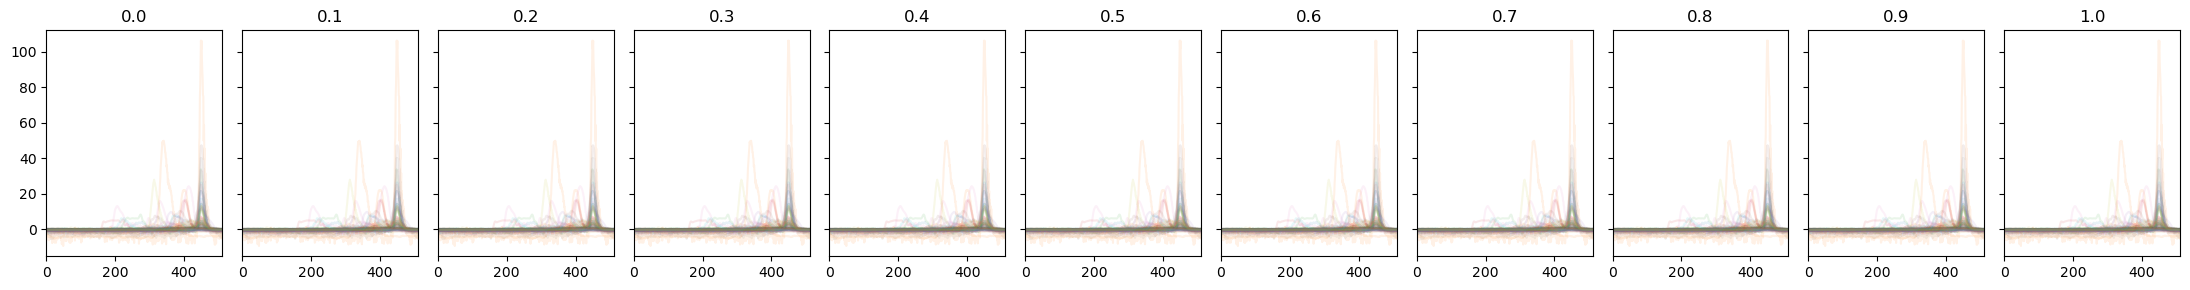

In [27]:
# 1) Define your condition grid (here 0.0 → 1.0 in steps of 0.1)
cond_values = np.round(np.linspace(0.0, 1.0, 11), 2)

# 2) Batch size & storage dict
batch_size    = 100
waveform_dict = {}

# 3) Prepare plotting grid
fig, axes = plt.subplots(
    nrows=1, ncols=len(cond_values),
    figsize=(len(cond_values)*2, 3),
    sharey=True
)
x_axis = np.arange(512)  # waveform length
z_t = torch.randn((batch_size, cp["config"]["Model"]["in_channels"], 512),
                    device=device)

# 4) Loop through each condition
for i, cond in enumerate(cond_values):
    # a) Sample noise & build cond tensor
    cond_tensor = torch.full((batch_size, 1), cond,
                             dtype=torch.float, device=device)

    # b) Run sampler (only final x₀)
    x = sampler(z_t, cond=cond_tensor,
                only_return_x_0=True,
                steps=steps, eta=eta, method=method)
    # x: [B, 1, 512]

    # c) To numpy & squeeze channel
    waveforms = x.cpu().numpy().squeeze(1)  # → (batch_size, 512)
    waveform_dict[cond] = waveforms

    # d) Plot stacked waveforms
    ax = axes[i]
    for wf in waveforms:
        ax.plot(x_axis, wf, alpha=0.1)
    ax.set_title(f"{cond:.1f}")
    ax.set_xlim(0, 511)

plt.tight_layout()
plt.show()


In [28]:
import pickle

with open("waveform_dict.pkl", "wb") as f:
    pickle.dump(waveform_dict, f)
print("Saved all waveforms → waveform_dict.pkl")


Saved all waveforms → waveform_dict.pkl


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectionSlider

# Ensure waveform_dict is in memory;
# if starting fresh, load it:
# import pickle
# with open("waveform_dict.pkl","rb") as f:
#     waveform_dict = pickle.load(f)

conds = sorted(waveform_dict.keys())

def plot_for_cond(cond):
    wfs = waveform_dict[cond]  # shape (batch_size, 512)
    x  = np.arange(wfs.shape[1])
    plt.figure(figsize=(6, 4))
    for wf in wfs:
        plt.plot(x, wf, alpha=0.1)
    plt.title(f"Tree-cover = {cond:.2f}")
    plt.xlim(0, wfs.shape[1] - 1)
    plt.show()

slider = SelectionSlider(
    options=[float(c) for c in conds],
    description="Tree-cover",
    continuous_update=True
)
interact(plot_for_cond, cond=slider)


interactive(children=(SelectionSlider(description='Tree-cover', options=(0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.…

<function __main__.plot_for_cond(cond)>